## Decomposing SST Reviews into subphrases of opposite sentiments

In [2]:
from torchtext import data, datasets
import torch
import os
from collections import Counter
import torch.nn.functional as F
import torch.autograd as autograd
import torch.nn as nn
import numpy as np
from ContextualDecomposition import CD

## Extract Data

In [3]:
inputs = data.Field(lower='preserve-case')
answers = data.Field(sequential=False, unk_token=None) # y: floats
train, dev, test = datasets.SST.splits(inputs, answers, fine_grained = False, train_subtrees = True)
inputs.build_vocab(train, dev, test)
inputs.vocab.load_vectors('glove.6B.300d')
answers.build_vocab(train)

/home/ckerriou/anaconda2/lib/python2.7/site-packages/nltk/tree.py:623: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif token == close_b:
/home/ckerriou/anaconda2/lib/python2.7/site-packages/nltk/tree.py:616: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if token[0] == open_b:


In [13]:
model =  torch.load('model.pt', map_location=lambda storage, loc: storage)

## Parse the reviews into positive and negative review with opposing sentiment subsentences

In [4]:
def parseTrees(train):
    # Output two list: Positive reviews, Negative reviews with opposing sentiment subsentences
    # List of tuples: (sentence, list of subsentence) where subsentences are of opposing sentiment to sentence.
    # The subsentences are of lengths 1/3 and 2/3 of the given sentence
    positivels = []
    negativels = []
    cur_sentence = []
    for _,sub in enumerate(train):
        # check if sub is subsentence of curr_sentence
        if set(sub.text).issubset(set(cur_sentence)):
            l = len(sub.text)
            # Check if length of subtree is between 1/3 and 2/3
            if (l <= cur_length*2/3.0) and (l >= cur_length/3.0) :
                # get sentiment of subsentence
                sentiment = sub.label
                # add subsentence to corresponding list, want opposing sentiment subphrases
                if sentiment == 'positive' and cur_sentiment == 'negative':
                    negativels[-1][1].append(sub)
                elif sentiment == 'negative' and cur_sentiment == 'positive':
                    positivels[-1][1].append(sub)
        else:
            cur_sentiment = sub.label
            if cur_sentiment == 'negative':
                negativels.append((sub, []))
            elif cur_sentiment == 'positive':
                positivels.append((sub,[]))
            cur_sentence = sub.text
            cur_length = len(cur_sentence)

    # remove all sentence with empty subphrase list
    pls = []
    nls = []
    for e in positivels:
        if len(e[1]): pls.append(e)
    for e in negativels:
        if len(e[1]): nls.append(e)
            
    return [pls, nls]

## Format the lists for the CD

In [5]:
def rolling_window(phrase, sub):
    tups = []
    for i in range(phrase.shape[0]):
        if i + len(sub) > phrase.shape[0]:
            break
        else:
            if np.array_equal(phrase[i:i+len(sub)], sub):
                tups.append((i, i+len(sub)-1))
    return tups

In [6]:
def format_indices(ls):
    formatted_ls = []
    for tup in ls:
        phrase = inputs.numericalize([tup[0].text], device=-1, train=False)
        subphrases = [inputs.numericalize([sub.text], device=-1, train=False) for sub in tup[1]]
        np_phrase = phrase.data.numpy()
        idx_tups = []
        for sub in subphrases:
            np_sub = sub.data.numpy()
            idx_tups += rolling_window(np_phrase, np_sub)
        formatted_ls.append((phrase, idx_tups))
    return formatted_ls

In [7]:
pls, nls = parseTrees(train)
pls = format_indices(pls)
nls = format_indices(nls)

In [8]:
# Input: list of phrase and corresponding subphrases
#        label of list: positive or negative phrases (with opposite sentiment subphrases)
#        model
def findSubphraseScores(ls, label, model):
    output = []
    for phrase, subIndexList in ls:
        for start,stop in subIndexList:
            e = CDAuthor(phrase, model, start, stop)
            output.append(e[0]-e[1])
    return output

In [14]:
plsScores = findSubphraseScores(pls, 'positive', model)
nlsScores = findSubphraseScores(nls, 'negative', model)

In [15]:
def decomp_three(a, b, c, activation):
    a_contrib = 0.5 * (activation(a + c) - activation(c) + activation(a + b + c) - activation(b + c))
    b_contrib = 0.5 * (activation(b + c) - activation(c) + activation(a + b + c) - activation(a + c))
    return a_contrib, b_contrib, activation(c)

def decomp_tanh_two(a, b):
    return 0.5 * (np.tanh(a) + (np.tanh(a + b) - np.tanh(b))), 0.5 * (np.tanh(b) + (np.tanh(a + b) - np.tanh(a)))
    

def makedirs(name):
    """helper function for python 2 and 3 to call os.makedirs()
       avoiding an error if the directory to be created already exists"""

    import os, errno

    try:
        os.makedirs(name)
    except OSError as ex:
        if ex.errno == errno.EEXIST and os.path.isdir(name):
            # ignore existing directory
            pass
        else:
            # a different error happened
            raise


def get_args():
    parser = ArgumentParser(description='PyTorch/torchtext SST')
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--batch_size', type=int, default=50)
    parser.add_argument('--d_embed', type=int, default=300)
    parser.add_argument('--d_proj', type=int, default=300)
    parser.add_argument('--d_hidden', type=int, default=128)
    parser.add_argument('--n_layers', type=int, default=1)
    parser.add_argument('--log_every', type=int, default=1000)
    parser.add_argument('--lr', type=float, default=.001)
    parser.add_argument('--dev_every', type=int, default=1000)
    parser.add_argument('--save_every', type=int, default=1000)
    parser.add_argument('--dp_ratio', type=int, default=0.2)
    parser.add_argument('--no-bidirectional', action='store_false', dest='birnn')
    parser.add_argument('--preserve-case', action='store_false', dest='lower')
    parser.add_argument('--no-projection', action='store_false', dest='projection')
    parser.add_argument('--train_embed', action='store_false', dest='fix_emb')
    parser.add_argument('--gpu', type=int, default=0)
    parser.add_argument('--save_path', type=str, default='results')
    parser.add_argument('--vector_cache', type=str, default=os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt'))
    parser.add_argument('--word_vectors', type=str, default='glove.6B.300d')
    parser.add_argument('--resume_snapshot', type=str, default='')
    args = parser.parse_args()
    return args

In [16]:
def softmax(x):
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)



In [17]:
import os
import pdb
import torch
import numpy as np
from argparse import ArgumentParser
from torchtext import data, datasets
from scipy.special import expit as sigmoid
import random

# batch of [start, stop) with unigrams working
def CDAuthor(batch, model, start, stop):
    weights = model.lstm.state_dict()

    # Index one = word vector (i) or hidden state (h), index two = gate
    W_ii, W_if, W_ig, W_io = np.split(weights['weight_ih_l0'], 4, 0)
    W_hi, W_hf, W_hg, W_ho = np.split(weights['weight_hh_l0'], 4, 0)
    b_i, b_f, b_g, b_o = np.split(weights['bias_ih_l0'].cpu().numpy() + weights['bias_hh_l0'].cpu().numpy(), 4)
    word_vecs = model.word_embeddings(batch)[0].data
    T = word_vecs.size(0)
    relevant = np.zeros((T, model.hidden_dim))
    irrelevant = np.zeros((T, model.hidden_dim))
    relevant_h = np.zeros((T, model.hidden_dim))
    irrelevant_h = np.zeros((T, model.hidden_dim))
    for i in range(T):
        if i > 0:
            prev_rel_h = relevant_h[i - 1]
            prev_irrel_h = irrelevant_h[i - 1]
        else:
            prev_rel_h = np.zeros(model.hidden_dim)
            prev_irrel_h = np.zeros(model.hidden_dim)

        rel_i = np.dot(W_hi, prev_rel_h)
        rel_g = np.dot(W_hg, prev_rel_h)
        rel_f = np.dot(W_hf, prev_rel_h)
        rel_o = np.dot(W_ho, prev_rel_h)
        irrel_i = np.dot(W_hi, prev_irrel_h)
        irrel_g = np.dot(W_hg, prev_irrel_h)
        irrel_f = np.dot(W_hf, prev_irrel_h)
        irrel_o = np.dot(W_ho, prev_irrel_h)

        if i >= start and i <= stop:
            rel_i = rel_i + np.dot(W_ii, word_vecs[i])
            rel_g = rel_g + np.dot(W_ig, word_vecs[i])
            rel_f = rel_f + np.dot(W_if, word_vecs[i])
            rel_o = rel_o + np.dot(W_io, word_vecs[i])            
        else:
            irrel_i = irrel_i + np.dot(W_ii, word_vecs[i])
            irrel_g = irrel_g + np.dot(W_ig, word_vecs[i])
            irrel_f = irrel_f + np.dot(W_if, word_vecs[i])
            irrel_o = irrel_o + np.dot(W_io, word_vecs[i])

        rel_contrib_i, irrel_contrib_i, bias_contrib_i = decomp_three(rel_i, irrel_i, b_i, sigmoid)
        rel_contrib_g, irrel_contrib_g, bias_contrib_g = decomp_three(rel_g, irrel_g, b_g, np.tanh)

        relevant[i] = rel_contrib_i * (rel_contrib_g + bias_contrib_g) + bias_contrib_i * rel_contrib_g
        irrelevant[i] = irrel_contrib_i * (rel_contrib_g + irrel_contrib_g + bias_contrib_g) + (rel_contrib_i + bias_contrib_i) * irrel_contrib_g

        if i >= start and i < stop:
            relevant[i] += bias_contrib_i * bias_contrib_g
        else:
            irrelevant[i] += bias_contrib_i * bias_contrib_g

        if i > 0:
            rel_contrib_f, irrel_contrib_f, bias_contrib_f = decomp_three(rel_f, irrel_f, b_f, sigmoid)
            relevant[i] += (rel_contrib_f + bias_contrib_f) * relevant[i - 1]
            irrelevant[i] += (rel_contrib_f + irrel_contrib_f + bias_contrib_f) * irrelevant[i - 1] + irrel_contrib_f * relevant[i - 1]

        o = sigmoid(np.dot(W_io, word_vecs[i]) + np.dot(W_ho, prev_rel_h + prev_irrel_h) + b_o)
        rel_contrib_o, irrel_contrib_o, bias_contrib_o = decomp_three(rel_o, irrel_o, b_o, sigmoid)
        new_rel_h, new_irrel_h = decomp_tanh_two(relevant[i], irrelevant[i])
        #relevant_h[i] = new_rel_h * (rel_contrib_o + bias_contrib_o)
        #irrelevant_h[i] = new_rel_h * (irrel_contrib_o) + new_irrel_h * (rel_contrib_o + irrel_contrib_o + bias_contrib_o)
        relevant_h[i] = o * new_rel_h
        irrelevant_h[i] = o * new_irrel_h

    W_out = model.hidden2label.weight.data
    
    # Sanity check: scores + irrel_scores should equal the LSTM's output minus model.hidden_to_label.bias
    scores = np.dot(W_out, relevant_h[T - 1])
    irrel_scores = np.dot(W_out, irrelevant_h[T - 1])

    return scores, irrel_scores

In [40]:
A = []
B = []
for a,b in plsScores:
    A.append((a-b))
for c,d in nlsScores:
    B.append((c-d))

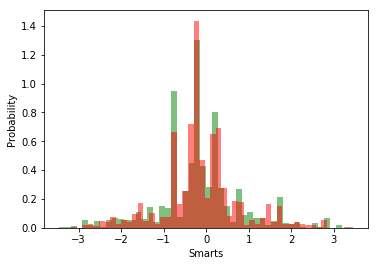

In [41]:

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(A, num_bins, normed=1, facecolor='green', alpha=0.5)
n, bins, patches = plt.hist(B, num_bins, normed=1, facecolor='red', alpha=0.5)
# add a 'best fit' line

plt.xlabel('Smarts')
plt.ylabel('Probability')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)




In [125]:
x = inputs.numericalize([["A"], ["painfully"], ["funny"], ["ode"], ["to"], ["bad"], ["behaviour"], ["."]], device=-1, train=False)
y = inputs.numericalize([["A"], ["bad"], ["movie"], ["."]], device=-1, train=False)


In [127]:
xx = CDAuthor(x,model,0,3)
yy = CDAuthor(y,model,0,3)

print(xx[0][0]-xx[0][1])
print(yy[0][0]-yy[0][1])

3.745513772380719
3.365864613372511


## Examples of parser

In [204]:
print("Main sentence: ")
print(sentencels[3][0].text)
print("Positive subsentence: ")
print(sentencels[3][1][0][0].text)
print ("Negative subsentence: ")
print(sentencels[3][1][1][0].text)

Main sentence: 
[u'have', u'had', u'enough', u'of', u'plucky', u'british', u'eccentrics', u'with', u'hearts', u'of', u'gold']
Positive subsentence: 
[u'with', u'hearts', u'of', u'gold']
Negative subsentence: 
[u'enough', u'of', u'plucky', u'british', u'eccentrics']


In [181]:
print("Main sentence: ")
print(sentencels[-1][0].text)
print("Positive subsentence: ")
print(sentencels[-1][1][1][0].text)
print ("Positive subsentence: ")
print(sentencels[-1][1][1][1].text)

Main sentence: 
[u'in', u'this', u'case', u'zero', u'.']
Positive subsentence: 
[u'case', u'zero', u'.']
Positive subsentence: 
[u'zero', u'.']


In [197]:
print("Main sentence: ")
print(sentencels[30][0].text)
print("Positive subsentence: ")
print(sentencels[30][1][0][0].text)

Main sentence: 
[u'next', u'pretty', u'good', u'thing']
Positive subsentence: 
[u'good', u'thing']
